- annotate each & `infercnvpy` for each
    - with `celltypist`
    - neftel score with `decoupler`
- scvi integration & bulk annotate

In [3]:
import os
import warnings
warnings.filterwarnings('ignore')

# scRNA-seq analysis pipeline
import scanpy as sc
import scanpy.external as sce
import pandas as pd
import numpy as np
# import decoupler as dc

# adjunctive
import infercnvpy as cnv
import celltypist
import mygene

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import mplscience
%matplotlib inline

# # Models & Calculation
from scipy.stats import median_abs_deviation as mad
import scipy.sparse as sp
import scvi
# from scvi import autotune
# from ray import tune
# import ray

In [2]:
# R integration
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
import anndata2ri
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

INFO:rpy2.situation:cffi mode is CFFI_MODE.ANY
INFO:rpy2.situation:R home found: /home/jiehoonk/micromamba/envs/sc_base_with_r/lib/R
INFO:rpy2.situation:R library path: 
INFO:rpy2.situation:LD_LIBRARY_PATH: 
INFO:rpy2.rinterface_lib.embedded:Default options to initialize R: rpy2, --quiet, --no-save
: Successfullly loaded R Profile
INFO:rpy2.rinterface_lib.embedded:R is already initialized. No need to initialize.


In [3]:
%%R
suppressPackageStartupMessages({
    # library(tidyverse)
    # library(Seurat)
    # library(scater)
    library(scDblFinder) 
    # library(BiocParallel)
    # library(scry)
})

In [4]:
def map_ensembl_to_symbols(var_index, species = "human"):
    ensembl_ids = list(var_index)
    results = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species=species)
    mapping_dict = {res['query']: res.get('symbol', res['query']) for res in results}
    return mapping_dict

def mad_outlier(adata, metric: str, nmads = 5, upper_only = False):
    M = adata.obs[metric]
    if not upper_only:
        return (M < np.median(M) - nmads * mad(M)) | (np.median(M) + nmads * mad(M) < M)
    return (M > np.median(M) + nmads * mad(M))

def qc(adata, species = "human"):
    sc.pp.filter_cells(adata, min_genes = 200)
    sc.pp.filter_genes(adata, min_counts=1)
    adata.var["mt"] = adata.var_names.str.startswith("MT-") if species == "human" else adata.var_names.str.startswith("mt-")
    adata.var['ribo'] = adata.var_names.str.startswith(('RPS', 'RPL')) if species == "human" else adata.var_names.str.startswith(('Rps', 'Rpl'))
    adata.var['hb'] = adata.var_names.str.contains(('^HB[^(P)]')) if species == "human" else adata.var_names.str.contains(('^Hb[^(p)]'))
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo', 'hb'], percent_top=[20], log1p=True, inplace=True) 
    
    not_need = ['total_counts_mt', 'log1p_total_counts_mt',
                'total_counts_ribo','log1p_total_counts_ribo',
                'total_counts_hb', 'log1p_total_counts_hb']
    
    adata.obs = adata.obs[[x for x in adata.obs.columns if x not in not_need]]
    print('Filtering cells below 200 genes and Returning adata with QC metrics')
    return adata
    
# codes from sanbomics
def qc_plot(adatas, value = "pct_counts_mt"):
    df = pd.concat([adata.obs for adata in adatas]).sort_values('sample_id')
    print("You can check for pct_counts_mt , n_genes , pct_counts_in_top_20_genes , log1p_total_counts")

    sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    g = sns.FacetGrid(df, row="sample_id", hue="sample_id", aspect=15, height=0.5, palette="tab20")
    g.map(sns.kdeplot, value, clip_on=False, fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, value, clip_on=False, color="w", lw=2)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
    g.map(label, value)
    g.figure.subplots_adjust(hspace=-.6)
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    for ax in g.axes.flat:
        ax.axvline(x=df[value].median(), color='r', linestyle='-')
    plt.show()
   

def pp(adata, mt_upper = 25):
    adata = adata[adata.obs.pct_counts_mt < mt_upper] 
    bool_vector = mad_outlier(adata, 'log1p_total_counts', 5) +\
            mad_outlier(adata, 'log1p_n_genes_by_counts', 5) +\
            mad_outlier(adata, 'pct_counts_in_top_20_genes', 5) +\
            mad_outlier(adata, 'pct_counts_mt', 3, upper_only = True)
    adata = adata[~bool_vector]
    adata.uns['cells_removed'] = sum(bool_vector)
    print('Returning adata with outliers removed')
    adata = remove_doublets(adata)
    return adata


def remove_doublets(adata):
    data_mat = adata.X.T
    %R -i data_mat -o doublet_score -o doublet_class set.seed(123);sce = scDblFinder(SingleCellExperiment(list(counts=data_mat))); doublet_score = sce$scDblFinder.score; doublet_class = sce$scDblFinder.class
    adata.obs["scDblFinder_score"] = doublet_score
    adata.obs["scDblFinder_class"] = doublet_class
    print(adata.obs.scDblFinder_class.value_counts())
    print('Returning adata with doublet removed')
    adata.uns["doublets_removed"] = sum(adata.obs["scDblFinder_class"] == "doublet")
    
    sce.pp.scrublet(adata, expected_doublet_rate=0.1)
    return adata[(adata.obs.scDblFinder_class == 'singlet') | ~(adata.obs.predicted_doublet)]

def print_clusters(df, n_genes = 5, resolution = 1, scvi = False):
    resolution_name = "leiden_res" + str(resolution).replace('.','_')
    clusters = adata.obs[resolution_name].cat.categories

    group = 'group' if not scvi else 'group1'
    if not scvi:
        for cluster in clusters:
            top_genes = df[df[group] == cluster].head(n_genes)['names']
            res = ', '.join(top_genes)
            print(f'Cluster {cluster}: {res}')
    else:
        for cluster in clusters:
            top_genes = df[df[group] == cluster].head(n_genes).index
            res = ', '.join(top_genes)
            print(f'Cluster {cluster}: {res}')
            
            
def annotate_with_markers(adata, gene_markers, resolution=0.5):
    resolution_name = "leiden_res" + str(resolution).replace('.','_')
    sc.tl.leiden(adata, key_added=f'{resolution_name}', resolution=resolution)
    for ct in gene_markers.keys(): 
        print(f"{ct.upper()}:")  
        sc.pl.umap(
            adata,
            color=gene_markers[ct],
            vmax="p99", 
            sort_order=False, 
            frameon=False,
            cmap="Reds", 
        )
        print("\n\n\n")
    sc.pl.dotplot(
        adata,
        groupby=resolution_name,
        var_names= gene_markers, 
        standard_scale="var", 
    )    

# 1. Load samples from output of `Cellbender` v8.0.0

In [5]:
def load_data(sample):
    adata = sc.read_10x_h5(os.path.join(data_dir, sample))
    
    sample = sample.split('_')[0]
    adata.obs['sample_id'] = sample
    adata.obs['tissue'] = adata.obs.index.map(lambda x: "Tumor" if sample[-1] == 'T' else "SVZ")
    adata.obs['patient_id'] = sample[:-1]
    adata.obs['author'] = 'tnl'
    adata.obs['barcode'] = adata.obs.index
    adata.obs.index = adata.obs['sample_id'] + "_" + adata.obs['barcode']
    adata.obs_names_make_unique()
    adata.var_names_make_unique()
    adata.X = adata.X.tocsc().astype(np.float32)
    return adata

data_dir = '../../processed_data/cellbender_out'
samples = [f for f in os.listdir(data_dir) if f.endswith('.h5')]
adatas = [load_data(sample) for sample in samples]

for adata in adatas:
    print(adata.obs['sample_id'][0], " : ", np.max(adata.X), np.min(adata.X))

S1T  :  475.0 0.0
S1V  :  1582.0 0.0
S2T  :  3087.0 0.0
S2V  :  2992.0 0.0
S3T  :  1058.0 0.0
S3V  :  258.0 0.0
S4T  :  4370.0 0.0
S4V  :  13294.0 0.0
S5T  :  6976.0 0.0
S5V  :  2366.0 0.0
S6T  :  31650.0 0.0
S6V  :  3348.0 0.0


# 2. Preprocess

In [6]:
adatas = [qc(adata, species="human") for adata in adatas] 

Filtering cells below 200 genes and Returning adata with QC metrics
Filtering cells below 200 genes and Returning adata with QC metrics
Filtering cells below 200 genes and Returning adata with QC metrics
Filtering cells below 200 genes and Returning adata with QC metrics
Filtering cells below 200 genes and Returning adata with QC metrics
Filtering cells below 200 genes and Returning adata with QC metrics
Filtering cells below 200 genes and Returning adata with QC metrics
Filtering cells below 200 genes and Returning adata with QC metrics
Filtering cells below 200 genes and Returning adata with QC metrics
Filtering cells below 200 genes and Returning adata with QC metrics
Filtering cells below 200 genes and Returning adata with QC metrics
Filtering cells below 200 genes and Returning adata with QC metrics


You can check for pct_counts_mt , n_genes , pct_counts_in_top_20_genes , log1p_total_counts


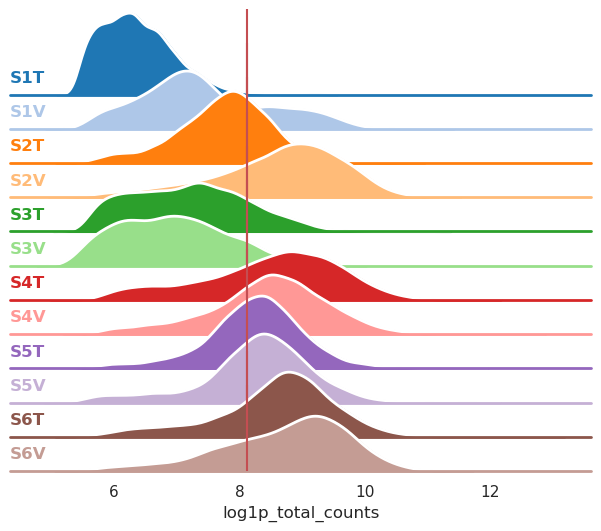

In [7]:
qc_plot(adatas, 'log1p_total_counts')

You can check for pct_counts_mt , n_genes , pct_counts_in_top_20_genes , log1p_total_counts


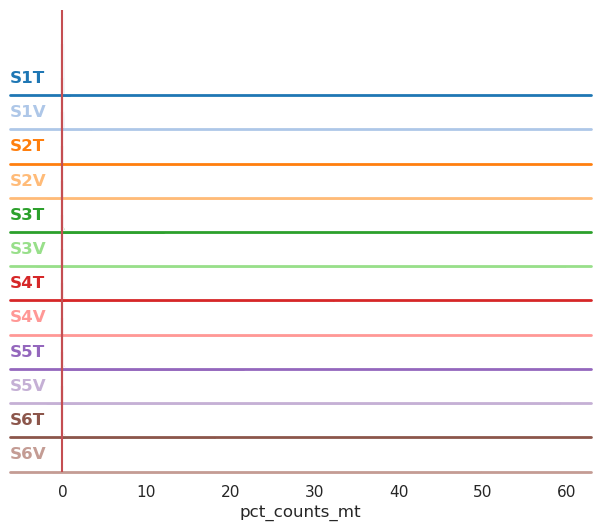

In [8]:
qc_plot(adatas, 'pct_counts_mt')

In [9]:
adatas = [pp(adata) for adata in adatas]

for adata in adatas:
    print("total cells :", len(adata), 
          ", removed cells :", adata.uns['cells_removed'], 
          ", removed doublets :", adata.uns['doublets_removed'], 
          ", removed doublet (scDblFinder) % : {:.2f} ".format(adata.uns['doublets_removed']/len(adata)*100),
          ", removed doublet (scrublet) % : {:.2f}".format(adata.obs.predicted_doublet.sum()/len(adata)*100))
    print('check doublet rate is about 4.5% in 5000 cells')

Returning adata with outliers removed


Creating ~5281 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 1045 cells excluded from training.
iter=1, 1045 cells excluded from training.
iter=2, 1045 cells excluded from training.
Threshold found:0.403
527 (8%) doublets called


scDblFinder_class
singlet    6074
doublet     527
Name: count, dtype: int64
Returning adata with doublet removed
Returning adata with outliers removed


Creating ~6283 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 1512 cells excluded from training.
iter=1, 1512 cells excluded from training.
iter=2, 1512 cells excluded from training.
Threshold found:0.425
870 (11.1%) doublets called


scDblFinder_class
singlet    6983
doublet     870
Name: count, dtype: int64
Returning adata with doublet removed
Returning adata with outliers removed


Creating ~5532 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 1225 cells excluded from training.
iter=1, 1225 cells excluded from training.
iter=2, 1225 cells excluded from training.
Threshold found:0.375
594 (8.6%) doublets called


scDblFinder_class
singlet    6321
doublet     594
Name: count, dtype: int64
Returning adata with doublet removed
Returning adata with outliers removed


Creating ~3016 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 527 cells excluded from training.
iter=1, 527 cells excluded from training.
iter=2, 527 cells excluded from training.
Threshold found:0.37
226 (6%) doublets called


scDblFinder_class
singlet    3544
doublet     226
Name: count, dtype: int64
Returning adata with doublet removed
Returning adata with outliers removed


Creating ~4126 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 697 cells excluded from training.
iter=1, 697 cells excluded from training.
iter=2, 697 cells excluded from training.
Threshold found:0.509
415 (8%) doublets called


scDblFinder_class
singlet    4742
doublet     415
Name: count, dtype: int64
Returning adata with doublet removed
Returning adata with outliers removed


Creating ~1500 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 181 cells excluded from training.
iter=1, 181 cells excluded from training.
iter=2, 181 cells excluded from training.
Threshold found:0.372
28 (3.4%) doublets called


scDblFinder_class
singlet    802
doublet     28
Name: count, dtype: int64
Returning adata with doublet removed
Returning adata with outliers removed


Creating ~6350 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 1848 cells excluded from training.
iter=1, 1848 cells excluded from training.
iter=2, 1848 cells excluded from training.
Threshold found:0.302
689 (8.7%) doublets called


scDblFinder_class
singlet    7248
doublet     689
Name: count, dtype: int64
Returning adata with doublet removed
Returning adata with outliers removed


Creating ~5241 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 978 cells excluded from training.
iter=1, 978 cells excluded from training.
iter=2, 978 cells excluded from training.
Threshold found:0.256
412 (6.3%) doublets called


scDblFinder_class
singlet    6139
doublet     412
Name: count, dtype: int64
Returning adata with doublet removed
Returning adata with outliers removed


Creating ~7212 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 1535 cells excluded from training.
iter=1, 1535 cells excluded from training.
iter=2, 1535 cells excluded from training.
Threshold found:0.284
958 (10.6%) doublets called


scDblFinder_class
singlet    8057
doublet     958
Name: count, dtype: int64
Returning adata with doublet removed
Returning adata with outliers removed


Creating ~1816 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 340 cells excluded from training.
iter=1, 340 cells excluded from training.
iter=2, 340 cells excluded from training.
Threshold found:0.303
105 (4.6%) doublets called


scDblFinder_class
singlet    2164
doublet     105
Name: count, dtype: int64
Returning adata with doublet removed
Returning adata with outliers removed


Creating ~3901 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 868 cells excluded from training.
iter=1, 868 cells excluded from training.
iter=2, 868 cells excluded from training.
Threshold found:0.38
366 (7.5%) doublets called


scDblFinder_class
singlet    4510
doublet     366
Name: count, dtype: int64
Returning adata with doublet removed
Returning adata with outliers removed


Creating ~2041 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 359 cells excluded from training.
iter=1, 359 cells excluded from training.
iter=2, 359 cells excluded from training.
Threshold found:0.372
111 (4.4%) doublets called


scDblFinder_class
singlet    2440
doublet     111
Name: count, dtype: int64
Returning adata with doublet removed
total cells : 6601 , removed cells : 128 , removed doublets : 527 , removed doublet (scDblFinder) % : 7.98  , removed doublet (scrublet) % : 0.00
check doublet rate is about 4.5% in 5000 cells
total cells : 7850 , removed cells : 1580 , removed doublets : 870 , removed doublet (scDblFinder) % : 11.08  , removed doublet (scrublet) % : 0.00
check doublet rate is about 4.5% in 5000 cells
total cells : 6536 , removed cells : 2934 , removed doublets : 594 , removed doublet (scDblFinder) % : 9.09  , removed doublet (scrublet) % : 1.35
check doublet rate is about 4.5% in 5000 cells
total cells : 3716 , removed cells : 863 , removed doublets : 226 , removed doublet (scDblFinder) % : 6.08  , removed doublet (scrublet) % : 0.13
check doublet rate is about 4.5% in 5000 cells
total cells : 5157 , removed cells : 3634 , removed doublets : 415 , removed doublet (scDblFinder) % : 8.05  , r

In [10]:
adatas

[View of AnnData object with n_obs × n_vars = 6601 × 28115
     obs: 'sample_id', 'tissue', 'patient_id', 'author', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet'
     var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
     uns: 'cells_removed', 'doublets_removed', 'scrublet',
 View of AnnData object with n_obs × n_vars = 7850 × 32498
     obs: 'sample_id', 'tissue', 'patient_id', 'author', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doubl

In [11]:
adata = sc.concat(adatas, join = 'outer')
adata.layers['counts'] = adata.X.copy()
adata.raw = adata

In [12]:
adata.write('../../intermediate_output/1_before_integration.h5ad')

... storing 'sample_id' as categorical
... storing 'tissue' as categorical
... storing 'patient_id' as categorical
... storing 'author' as categorical
... storing 'barcode' as categorical


# 3. Normalize & scVI integration

In [14]:
batch_key = 'sample_id'

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

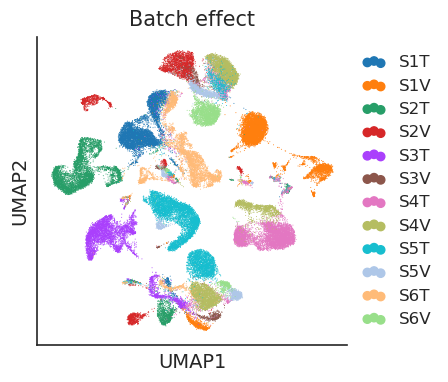

In [15]:
# check for batch effect 
bdata = adata.copy()
sc.pp.highly_variable_genes(bdata)
sc.tl.pca(bdata)
sc.pp.neighbors(bdata)
sc.tl.umap(bdata)
with mplscience.style_context():
    sc.pl.umap(bdata, color=[batch_key], title = "Batch effect") 
    plt.show()
del bdata

- run autotune & scVI integration in `Runpod`, refer to [2_tnl_runpod.ipynb](../tnl/2_tnl_runpod.ipynb)

# 4. Clustering and annotation
- bulk annotate with `celltypist` and `decoupler-py` markers
- then split into batches, re-annotate and inf `CNV`

In [4]:
adata = sc.read_h5ad('../../intermediate_output/2_after_scvi_autotune.h5ad')
adata

AnnData object with n_obs × n_vars = 62649 × 36579
    obs: 'sample_id', 'tissue', 'patient_id', 'author', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'leiden'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

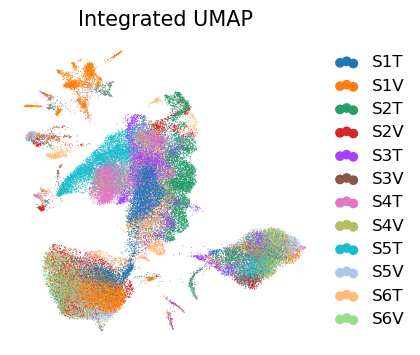

In [6]:
np.random.seed(777)
ri = np.random.permutation(list(range(adata.shape[0])))
with mplscience.style_context():
    sc.pl.umap(adata[ri,:], color = ['sample_id', 'tissue'], title = "Integrated UMAP", show=False, frameon=False)

## 1> celltypist

In [7]:
celltypist.models.download_models(force_update = True)

INFO:celltypist.logger:📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
INFO:celltypist.logger:📚 Total models in list: 52
INFO:celltypist.logger:📂 Storing models in /home/jiehoonk/.celltypist/data/models
INFO:celltypist.logger:💾 Downloading model [1/52]: Immune_All_Low.pkl
INFO:celltypist.logger:💾 Downloading model [2/52]: Immune_All_High.pkl
INFO:celltypist.logger:💾 Downloading model [3/52]: Adult_COVID19_PBMC.pkl
INFO:celltypist.logger:💾 Downloading model [4/52]: Adult_CynomolgusMacaque_Hippocampus.pkl
INFO:celltypist.logger:💾 Downloading model [5/52]: Adult_Human_MTG.pkl
INFO:celltypist.logger:💾 Downloading model [6/52]: Adult_Human_PancreaticIslet.pkl
INFO:celltypist.logger:💾 Downloading model [7/52]: Adult_Human_PrefrontalCortex.pkl
INFO:celltypist.logger:💾 Downloading model [8/52]: Adult_Human_Skin.pkl
INFO:celltypist.logger:💾 Downloading model [9/52]: Adult_Mouse_Gut.pkl
INFO:celltypist.logger:💾 Downloading model [10/52]: Adult_Mouse_Olf

In [ ]:
# Developing_Human_Brain.pkl
# Human_AdultAged_Hippocampus.pkl
# GBmap_ref_model.pkl

wb_model = celltypist.models.Model.load(model = 'Mouse_Whole_Brain.pkl')

bdata = adata.copy()
sc.pp.normalize_total(bdata, target_sum=1e4)
sc.pp.log1p(bdata)
predictions = celltypist.annotate(bdata, model = wb_model, mode = 'prob match', p_thres=0.5)
predictions_adata = predictions.to_adata()
adata.obs['wb_anno'] = predictions_adata.obs['predicted_labels']
adata.obs['wb_conf_score'] = predictions_adata.obs['conf_score']

del predictions_adata
del bdata

## 2> decoupler